In [1]:
from hands import process
import os
import imageio.v3 as imageio
from matplotlib import pyplot as plt
import numpy as np
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.src.models import Sequential
from keras.src.layers import Dense

2024-11-04 15:25:14.388453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
asl_dict = {char: [] for char in string.digits + string.ascii_lowercase}
asl_dir = "asl_dataset"

sub_dirs = sorted([d for d in os.listdir(asl_dir) if os.path.isdir(os.path.join(asl_dir, d))])

for dir in sub_dirs:
    cur = os.path.join(asl_dir,dir)
    for img in os.listdir(cur):
        image_path = os.path.join(cur, img)
        im = imageio.imread(image_path)
        frame, landmarks = process(im, False, 1)
        try:
            asl_dict[dir].append(landmarks)
        except Exception as e:
            print(f'{e}: error adding to dict')

I0000 00:00:1730762728.912614 8729711 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 5300M OpenGL Engine
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730762729.005027 8730047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730762729.037016 8730038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730762729.051951 8730042 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/jagan-kalsi/Desktop/class/csc/csc487/asl/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. Sym

In [8]:
X = []
y = []

# Collect landmarks and corresponding labels
for label, landmarks_list in asl_dict.items():
    for landmarks in landmarks_list:
        if landmarks is not None and len(landmarks) == 63:  # Ensure landmarks are valid
            X.append(landmarks)
            y.append(label)

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # Shape: (n_samples, 63)
y = np.array(y)  # Keep y as an array of strings for encoding

# Encode the labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Now y_encoded is numeric

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [9]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)), 
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Users/jagan-kalsi/Desktop/class/csc/csc487/asl/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0488 - loss: 3.5468 - val_accuracy: 0.0798 - val_loss: 3.3942
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1064 - loss: 3.3346 - val_accuracy: 0.1779 - val_loss: 3.0982
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1921 - loss: 2.9763 - val_accuracy: 0.2761 - val_loss: 2.6539
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3092 - loss: 2.5150 - val_accuracy: 0.3436 - val_loss: 2.2393
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3662 - loss: 2.1169 - val_accuracy: 0.4448 - val_loss: 1.8822
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4887 - loss: 1.7258 - val_accuracy: 0.5307 - val_loss: 1.6134
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6229 - loss: 1.3884 - val_accuracy: 0.6687 - val_loss: 1.2743
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7331 - loss: 1.0711 - val_accuracy: 0.7086 - val_loss:

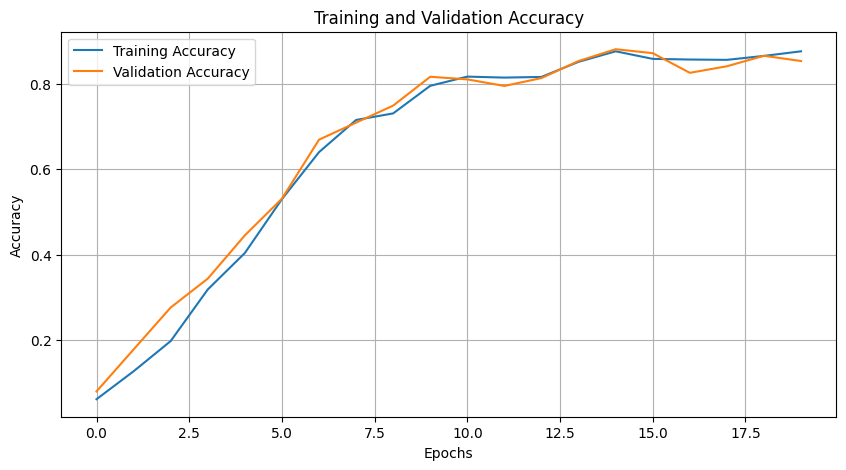

In [11]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()